# Depth Analysis (only Left Hand)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import iqr
import cv2

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# Positioning ROIs:
# Body
POS_BODY_FILE = '../data/positions/capture_example_01/roi_position.pkl'
# Antenna
POS_ANTENNA_FILE = '../data/positions/capture_example_01/antenna_position.pkl'
# Dataset of depth captures
DEPTH_DATASET_FILE = '../data/positions/capture_example_01/c_2021_24_07_17_42_37_depth.pkl'
# ROI defined for the dataset
ROI_DEFINITION_FILE = '../data/positions/capture_example_01/roi.pkl'
# Original image size
ORIGINAL_WIDTH = 640
ORIGINAL_HEIGHT = 400
# These parameters come from intrinsics matrix (RIGHT)
CX = 318.04592896
CY = 198.99064636
FX = 427.05795288
FY = 427.38696289

In [4]:
fidant = open(POS_ANTENNA_FILE, 'rb')
antenna = pickle.load(fidant)
fidbod = open(POS_BODY_FILE, 'rb')
body = pickle.load(fidbod)
fid = open(DEPTH_DATASET_FILE, 'rb')
ds = pickle.load(fid)
fidroi = open(ROI_DEFINITION_FILE, "rb")
roi = pickle.load(fidroi)

In [5]:
antenna

{'absolute': {'topx': 97, 'topy': 51, 'bottomx': 76, 'bottomy': 69},
 'relative': {'topx': 0.1515625,
  'topy': 0.1275,
  'bottomx': 0.11875,
  'bottomy': 0.1725},
 'x': -314.7727966308594,
 'y': 188.3256072998047,
 'z': 594.0}

In [6]:
body

{'topl': [0.45, 0.15000000000000008],
 'bottomr': [0.65, 0.35],
 'x': 65.58332824707031,
 'y': 204.94790649414062,
 'z': 905.0}

In [7]:
roi

{'right_hand': {'topx': 0.1828125,
  'bottomx': 0.5359375,
  'topy': 0.04,
  'bottomy': 0.455},
 'left_hand': {'topx': 0.709375,
  'bottomx': 0.9203125,
  'topy': 0.175,
  'bottomy': 0.6625}}

In [13]:
# depth limits
depth_threshold_min = antenna['z'] + 5
depth_threshold_max = body['z'] - 50

In [23]:
# Left Hand
x_coordinate_mm = lambda x, z: ((x - CX)*z)/FX
x_coordinate_px = lambda x: int(x * ORIGINAL_WIDTH)
y_coordinate_mm = lambda y, z: ((y - CY)*z)/FY            
y_coordinate_px = lambda y: int(y * ORIGINAL_HEIGHT)
# Fixed parameters left hand
topx_lh = x_coordinate_px(roi['left_hand']['topx'])
bottomx_lh = x_coordinate_px(roi['left_hand']['bottomx']) 
topy_lh = y_coordinate_px(roi['left_hand']['topy'])
bottomy_lh = y_coordinate_px(roi['left_hand']['bottomy'])
# Get yz limits (left hand)
min_y_min_z_lh = y_coordinate_mm(bottomy_lh, depth_threshold_min)
max_y_min_z_lh = y_coordinate_mm(topy_lh, depth_threshold_min)
min_y_max_z_lh = y_coordinate_mm(bottomy_lh, depth_threshold_max)
max_y_max_z_lh = y_coordinate_mm(topy_lh, depth_threshold_max) 

In [16]:
y_min = min(min_y_min_z_lh, max_y_min_z_lh, min_y_max_z_lh, max_y_max_z_lh)
y_max = max(min_y_min_z_lh, max_y_min_z_lh, min_y_max_z_lh, max_y_max_z_lh)

In [17]:
print(y_min, y_max)

-258.04952470247775 132.053624145587


## Draw yz limits

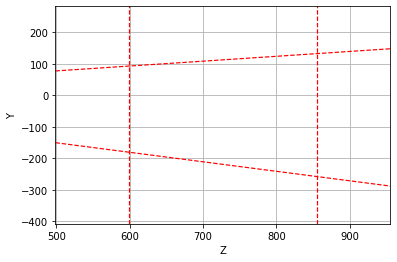

In [30]:
# Draw yz region
fig, ax = plt.subplots(figsize=(6,4))
plt.grid()
# set limits
ax.set_ylim((y_min - 150, y_max + 150))
ax.set_xlim((depth_threshold_min - 100, depth_threshold_max + 100))
# draw limiting region
y0, y1 = ax.get_ylim()
ax.axline((depth_threshold_min, y0), (depth_threshold_min, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_max, y0), (depth_threshold_max, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, min_y_min_z_lh), (depth_threshold_max, min_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, max_y_min_z_lh), (depth_threshold_max, max_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.set_xlabel("Z")
ax.set_ylabel("Y")
plt.show()

In [18]:
# Process dataset
dm_lh = []
dm_rh = []
for dm in ds:
    if dm['hand'] == 'left':
        dm_lh.append(dm)
    else:
        dm_rh.append(dm)

In [45]:
size_lh = len(dm_lh)
depth_map_dim_lh = dm_lh[0]['depth_map'].shape
from_ts_lh = dm_lh[0]['timestamp']
to_ts_lh = dm_lh[size_lh-1]['timestamp']
from_frame_num_lh = dm_lh[0]['frame']
to_frame_num_lh = dm_lh[size_lh-1]['frame']
roi_topx_lh = topx_lh
roi_topy_lh = topy_lh
roi_bottomx_lh = bottomx_lh
roi_bottomy_lh = bottomy_lh

## Dataset Metadata Left Hand

In [46]:
print(f"Dataset size = {size_lh} frames")
print(f"Depth map width = {depth_map_dim_lh[1]} pixels")
print(f"Depth map height = {depth_map_dim_lh[0]} pixels")
print(f"From time = {from_ts_lh}")
print(f"To time = {to_ts_lh}")
print(f"From frame = {from_frame_num_lh}")
print(f"To frame = {to_frame_num_lh}")
print(f"ROI top (x,y) = ({roi_topx_lh},{roi_topy_lh})")
print(f"ROI bottom (x,y) = ({roi_bottomx_lh},{roi_bottomy_lh})")

Dataset size = 451 frames
Depth map width = 136 pixels
Depth map height = 196 pixels
From time = 2021-07-24 17:43:35.550569
To time = 2021-07-24 17:43:50.557400
From frame = 1677
To frame = 2127
ROI top (x,y) = (454,70)
ROI bottom (x,y) = (589,265)


## Inspect Dataset Left Hand

In [48]:
size = size_lh
dataset = dm_lh

In [49]:
CURRENT_SLICE = 0
slice_size = 16
slices = size//slice_size + (0 if size%slice_size==0 else 1)
def show_slice(slice_number):
    global CURRENT_SLICE
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        axs[row,col].imshow(sl_['depth_map'], cmap='Spectral')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()
    CURRENT_SLICE = slice_number

In [50]:
interact(show_slice, 
         slice_number=widgets.IntSlider(min=0, max=slices-1, step=1, description='Select Slice')
)

interactive(children=(IntSlider(value=0, description='Select Slice', max=28), Output()), _dom_classes=('widget…

<function __main__.show_slice(slice_number)>

## Threshold z

In [51]:
MAX_DEPTH_VALUE = depth_threshold_max
MIN_DEPTH_VALUE = depth_threshold_min

In [52]:
MIN_DEPTH_VALUE, MAX_DEPTH_VALUE

(599.0, 855.0)

In [53]:
# Show dataset filtered
def show_filtered_slice(slice_number):
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        # Max values turn to 0 for display
        dm_ = sl_['depth_map'].copy()
        filter_1 = dm_ > MAX_DEPTH_VALUE
        dm_[filter_1] = 2**16
        axs[row,col].imshow(dm_, cmap='rainbow')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()

In [56]:
CURRENT_SLICE

22

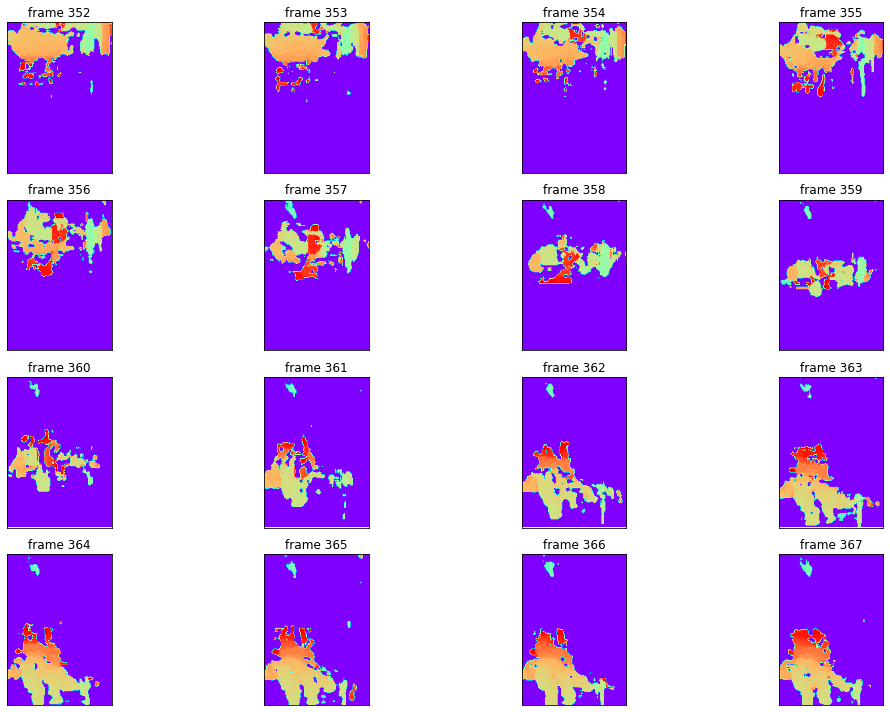

In [57]:
show_filtered_slice(CURRENT_SLICE)

## Select Frame

In [58]:
FRAME = 352

In [59]:
dm_frame = dataset[FRAME]['depth_map']
frame_number = dataset[FRAME]['frame']
ts = dataset[FRAME]['timestamp']

In [60]:
filter_cond = (dm_frame > MAX_DEPTH_VALUE) | (dm_frame < MIN_DEPTH_VALUE)
dm_frame_filtered = dm_frame.copy()
dm_frame_filtered_idxs = np.argwhere(~filter_cond)
dm_frame_filtered_values = dm_frame[~filter_cond].flatten()
dm_frame_filtered[filter_cond] = 2**16

In [61]:
# Some statistics of the frame depth values
print("Statistics of Thresholed Frame")
print(f"Size = {len(dm_frame_filtered_values)}")
print(f"Min = {np.max(dm_frame_filtered_values)}")
print(f"Max = {np.min(dm_frame_filtered_values)}")
print(f"Mean = {np.mean(dm_frame_filtered_values)}")
print(f"Median = {np.median(dm_frame_filtered_values)}")
print(f"Std = {np.std(dm_frame_filtered_values)}")

Statistics of Thresholed Frame
Size = 3869
Min = 850
Max = 603
Mean = 666.7304212974929
Median = 637.0
Std = 67.86431095444499


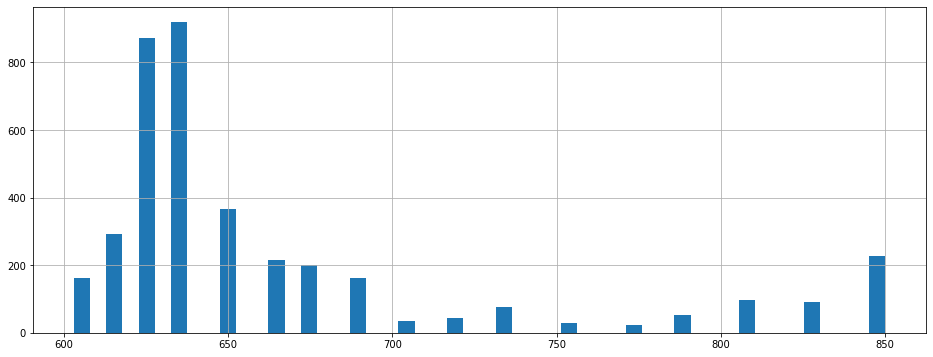

In [62]:
fig = plt.figure(figsize=(16,6))
plt.grid()
plt.hist(dm_frame_filtered_values, bins=50)
plt.show()

In [63]:
dm_frame_filtered.shape

(196, 136)

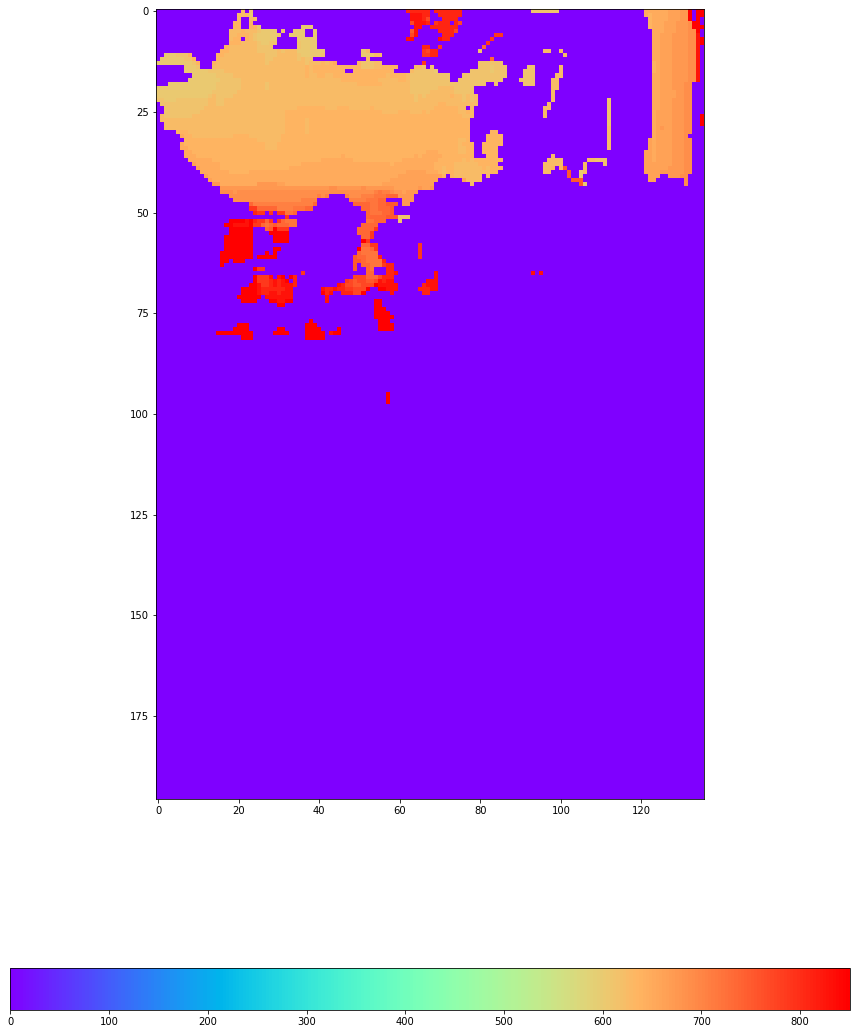

In [64]:
fig = plt.figure(figsize=(12,16))
plt.imshow(dm_frame_filtered, cmap='rainbow')
plt.colorbar(orientation='horizontal')
fig.tight_layout()
plt.show()

## YZ Projection

In [65]:
# Numpy version is faster
def xyz_numpy(frame, idxs, topx, topy, cx, cy, fx, fy):
    u = idxs[:,1]
    v = idxs[:,0]
    z = frame[v,u]
    x = ((u + topx - cx)*z)/fx
    y = ((v + topy - cy)*z)/fy
    return x, y, z

In [74]:
# Filtered
dm_ = dm_frame.copy()
filter_cond = (dm_ > MAX_DEPTH_VALUE) | (dm_ < MIN_DEPTH_VALUE)
dm_frame_filtered_idxs = np.argwhere(~filter_cond)
x, y, z = xyz_numpy(dm_, dm_frame_filtered_idxs, roi_topx_lh, roi_topy_lh, CX, CY, FX, FY)

In [67]:
x

array([229.70253507, 228.53525841, 374.53204728, ..., 384.04848634,
       384.04848634, 384.04848634])

In [82]:
# Centroids
centroid_x = np.mean(x)
centroid_z = np.mean(z)
centroid_y = np.mean(y)
# Quantiles
Q1_z = np.quantile(z, 0.25)
Q3_z = np.quantile(z, 0.75)
iqr_z = Q3_z - Q1_z
Q1_x = np.quantile(x, 0.25)
Q3_x = np.quantile(x, 0.75)
iqr_x = Q3_x - Q1_x
Q1_y = np.quantile(y, 0.25)
Q3_y = np.quantile(y, 0.75)
iqr_y = Q3_y - Q1_y

In [83]:
centroid_y, centroid_z

(-151.3933938907451, 666.7304212974929)

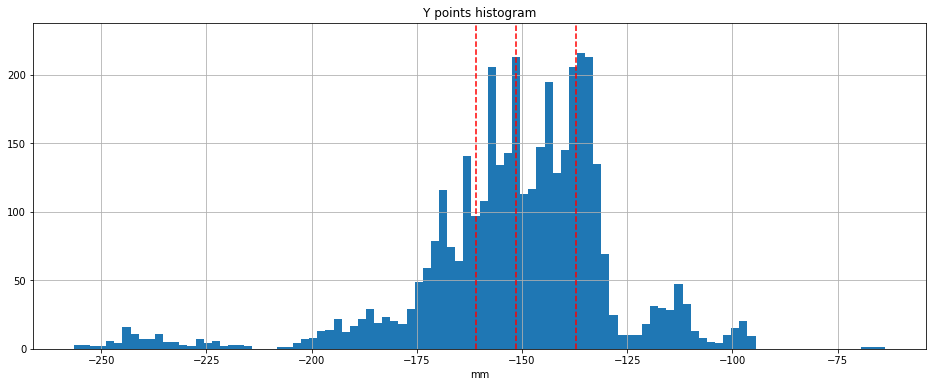

In [84]:
fig, ax = plt.subplots(figsize=(16,6))
plt.grid()
ax.hist(y, bins=100)
ax.set_title("Y points histogram")
ax.set_xlabel("mm")
y0, y1 = ax.get_ylim()
ax.axline((centroid_y, y0), (centroid_y, y1), color='r', ls='dashed')
ax.axline((Q1_y, y0), (Q1_y, y1), color='r', ls='dashed')
ax.axline((Q3_y, y0), (Q3_y, y1), color='r', ls='dashed')
plt.show()

# Plot points (the Y points are inverted)

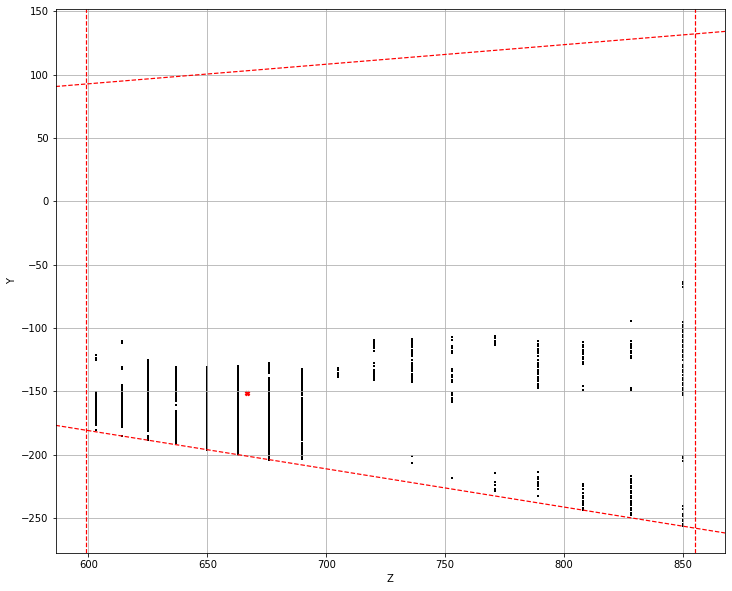

In [85]:
fig, ax = plt.subplots(figsize=(12,10))
y0, y1 = ax.get_ylim()
plt.grid()
plot = ax.scatter(z, y, marker='+', color='k', s=2.2)
ax.scatter(centroid_z, centroid_y, marker='X', color='r', s=20)
ax.axline((depth_threshold_min, y0), (depth_threshold_min, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_max, y0), (depth_threshold_max, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, min_y_min_z_lh), (depth_threshold_max, min_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, max_y_min_z_lh), (depth_threshold_max, max_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.set_xlabel("Z")
ax.set_ylabel("Y")
plt.show()

In [86]:
# Filter outliers
# quantiles
q1y, q3y = np.quantile(y, [0.25, 0.75])
q1z, q3z = np.quantile(z, [0.25, 0.75])
iqry = q3y - q1y
iqrz = q3z - q1z
# limits to determine outliers
liminfy = q1y - 1.5*iqry
limsupy = q3y + 1.5*iqry
liminfz = q1z - 1.5*iqrz
limsupz = q3z + 1.5*iqrz
# filter outliers (only include points between liminf and limsup)
points_yz = np.vstack([y, z])
cond_y = (points_yz[0,:] >= liminfy) & (points_yz[0,:] <= limsupy)
cond_z = (points_yz[1,:] >= liminfz) & (points_yz[1,:] <= limsupz)
filterd_yz = points_yz[:,cond_y | cond_z]
filtered_centroid_x = np.mean(filterd_yz[0,:])
filtered_centroid_z = np.mean(filterd_yz[1,:])

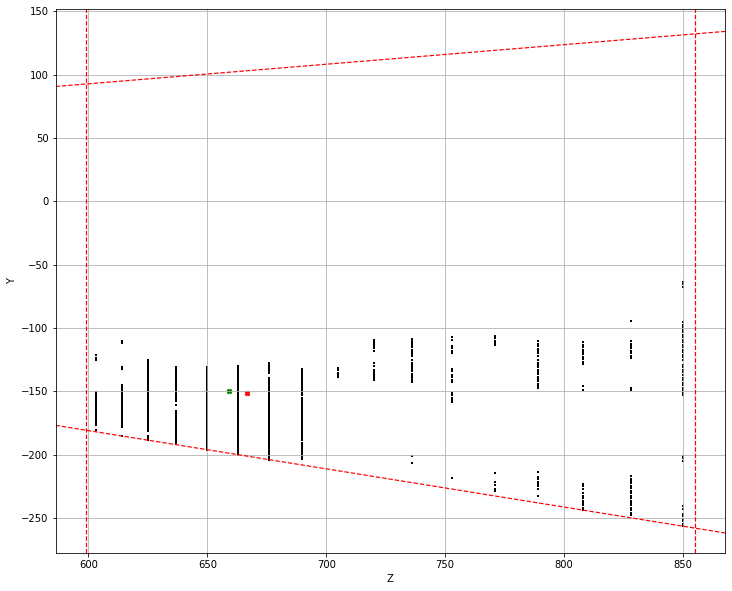

In [91]:
fig, ax = plt.subplots(figsize=(12,10))
y0, y1 = ax.get_ylim()
plt.grid()
plot = ax.scatter(z, y, marker='+', color='k', s=2.2)
ax.scatter(centroid_z, centroid_y, marker='X', color='r', s=20)
ax.scatter(filtered_centroid_z, filtered_centroid_x, marker='X', color='g', s=20)
ax.axline((depth_threshold_min, y0), (depth_threshold_min, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_max, y0), (depth_threshold_max, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, min_y_min_z_lh), (depth_threshold_max, min_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, max_y_min_z_lh), (depth_threshold_max, max_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.set_xlabel("Z")
ax.set_ylabel("Y")
plt.show()

## Y points are inverted

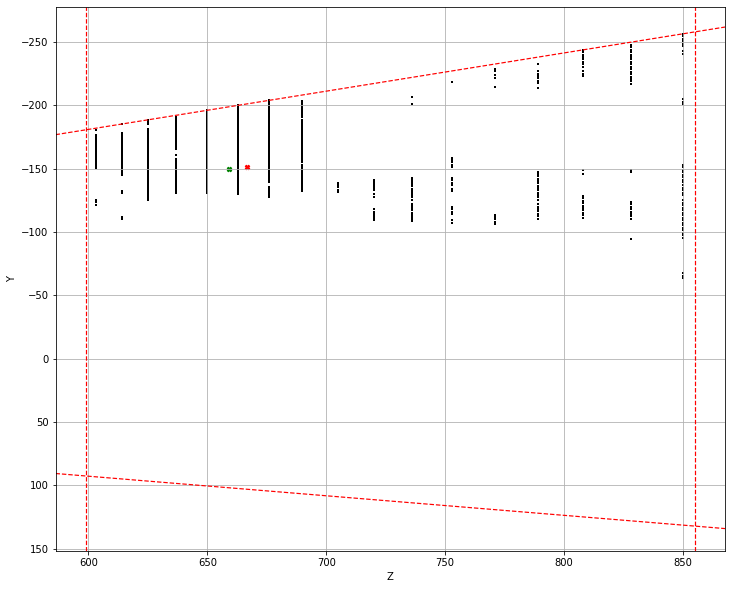

In [89]:
fig, ax = plt.subplots(figsize=(12,10))
y0, y1 = ax.get_ylim()
plt.grid()
plot = ax.scatter(z, y, marker='+', color='k', s=2.2)
ax.scatter(centroid_z, centroid_y, marker='X', color='r', s=20)
ax.scatter(filtered_centroid_z, filtered_centroid_x, marker='X', color='g', s=20)
ax.axline((depth_threshold_min, y0), (depth_threshold_min, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_max, y0), (depth_threshold_max, y1), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, min_y_min_z_lh), (depth_threshold_max, min_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.axline((depth_threshold_min, max_y_min_z_lh), (depth_threshold_max, max_y_max_z_lh), ls='dashed', color='r', linewidth=1.2)
ax.invert_yaxis()
ax.set_xlabel("Z")
ax.set_ylabel("Y")
plt.show()